# First order low-pass RC filter
This notebook shows how to use SymPy, Schemdraw, SciPy, and matplotlib to simulate the frequency response and step response of a first-order RC filter.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import schemdraw
import schemdraw.elements as elm

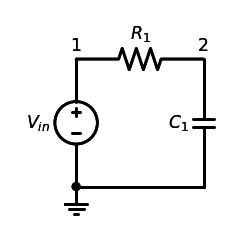

In [2]:
with schemdraw.Drawing(file='RC_LP.jpg') as d:
    V1 = d.add(elm.SourceV(rgtlabel='1').up().label('$V_{in}$'))
    R1 = d.add(elm.Resistor().right().label('$R_1$'))
    C1 = d.add(elm.Capacitor(rgtlabel='2').down().label('$C_1$'))     
    L1=d.add(elm.LINE, d='left', to=V1.start) 
    d.add(elm.GND)
    d.add(elm.DOT,xy=V1.start)
     

We can use voltage division and impedances to write the transfer function.
$$ H(s)=\frac{\frac{1}{R_1C_1}}{s+\frac{1}{R_1C_1}}=\frac{\omega_0}{s+\omega_0} $$
This can be put into a signal flow graph as shown below:


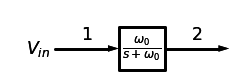

In [3]:
from schemdraw import dsp 
with schemdraw.Drawing(file='signal.jpg') as d:    
    a1=d.add(dsp.Arrow(l=d.unit/2, label='1').label('$V_{in}$', loc='left'))
    g1= d.add(dsp.Box(w=1.1, h=1, label='$\\frac{\omega_0}{s+\omega_0}$', anchor='W'))
    a2=d.add(dsp.Arrow('right', l=d.unit/2, xy=g1.E,label='2'))

     

We can now call Node 2 Vout.

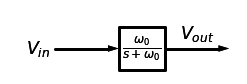

In [4]:
with schemdraw.Drawing(file='signal.jpg') as d:   
    a1=d.add(dsp.Arrow(l=d.unit/2).label('$V_{in}$', loc='left'))
    g1= d.add(dsp.Box(w=1.1, h=1, label='$\\frac{\omega_0}{s+\omega_0}$', anchor='W'))
    a2=d.add(dsp.Arrow('right', l=d.unit/2, xy=g1.E,label='$V_{out}$'))


We can write:
$$V_{out}=\frac{\omega_0}{s+\omega_0} \times V_{in}$$

In [5]:
from sympy import symbols
from sympy import *
s= symbols("s", positive=True)
t= symbols("t", real=True)
R1, C1 = symbols("R1,C1,",real=True, positive=True)

The transfer function in Sympy is:

In [6]:
H=1/R1/C1/(s+1/R1/C1)
H

1/(C1*R1*(s + 1/(C1*R1)))

Now that we have the transfer function, we can find a function for the step response.

In [7]:
# Prepare for Bode Plot. (Need poles and zeros.)
num,de=fraction(H)


In [8]:
#We need numerical poles and zeros toplot Bode plot.
# Set R and C vlaues for plotting
res=100e3
cap=10e-6
de=de.subs(R1,res)
de=de.subs(C1,cap)
num=num.subs(R1,res)
num=num.subs(C1,cap)
poles=roots(de,s)
zeros=roots(num,s)
num_coeffs = Poly(num, s).coeffs()
de_coeffs = Poly(de, s).coeffs()
Gain=float(num_coeffs[0]/de_coeffs[0])

In [9]:
# Go though list of poles and zeros and make a list for the Bod plot function.
import numpy as np
plist=[]
for root, multiplicity in poles.items():
    plist.append(float(root))
plist=np.array(plist) 
nlist=[]
for root, multiplicity in zeros.items():
    nlist.append(float(root))
nlist=np.array(nlist) 


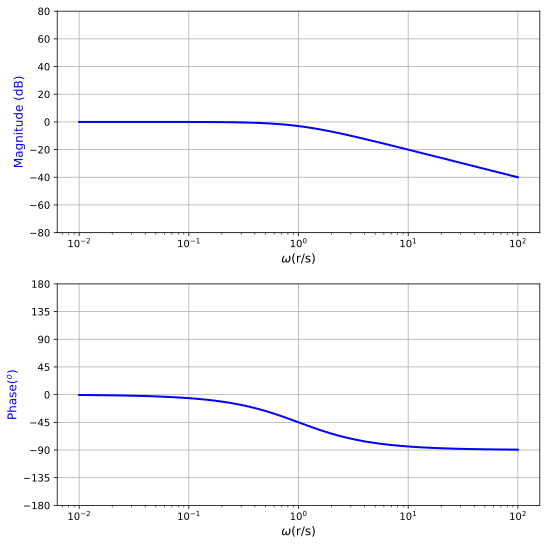

In [10]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
# N and D are a list of zeros and poles

N=nlist
D=plist
# autmoatically find the plotting range.
wo_min=(np.log10(abs(np.amin(D))))
wo_max=(np.log10(abs(np.amax(D))))
w=np.logspace(wo_min-2,wo_max+2,50)
#Create system that in zero, pole and gain format.
system = signal.lti(N, D,[Gain])
#Create Bode plot object
w, mag, phase = signal.bode(system,w)
#Create Bode Plot
axis_color = 'lightgoldenrodyellow'
 
fig, (ax, ax1) = plt.subplots(2,1,figsize=(8,8)) 
fig.subplots_adjust(left=0.25, bottom=0.25)
[line] = ax.semilogx(w,mag, linewidth=2, color='blue')

ax.set_xlabel('$\omega$(r/s)',fontsize=12)
ax.set_ylabel('Magnitude (dB)', color='b', fontsize=12) 
 
[line1] = ax1.semilogx(w,phase, linewidth=2, color='blue')
ax1.set_ylabel('Phase($^o$)', color='b', fontsize=12 ) 
ax1.set_xlabel('$\omega$(r/s)',fontsize=12)
ax1.yaxis.set_ticks(np.arange(-180,225, 45.0))
ax.yaxis.set_ticks(np.arange(-80,90, 20.0))
ax.grid()
ax1.grid()
plt.tight_layout(pad=2, w_pad=2, h_pad=1.0)
plt.show()
 




Now that we have the transfer function, we can find a function for the step response.

In [11]:
G=1/s
F=H*G
z=inverse_laplace_transform(F,s,t).evalf().simplify()
z

Heaviside(t) - exp(-t/(C1*R1))*Heaviside(t)

Note: In SymPy $$\Theta(t)=u(t)$$.

z(t)=g(t)*(t)=Heaviside(t) - exp(-t/(C1*R1))*Heaviside(t)
f(t)=Heaviside(t) - exp(-1.0*t)*Heaviside(t)


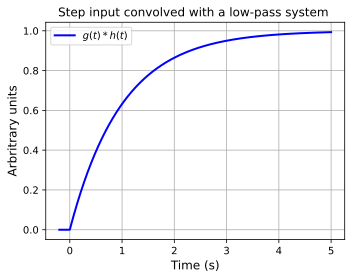

In [13]:
print('z(t)=g(t)*(t)={}'.format(z))
f=z
f=f.subs(R1,res)
f=f.subs(C1,cap)
print('f(t)={}'.format(f)) 
N=1000
Tau=res*cap
t_start=-.2*Tau
t_end=5*Tau
time=np.linspace( t_start,t_end,N)
flam = lambdify(t, f, "numpy")
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
fig.subplots_adjust(left=0.25, bottom=0.25)
legend='$g(t)*h(t) $'
[line] = ax.plot(time, flam(time), linewidth=2, color='blue',label=legend)
ax.set_xlabel('Time (s)',fontsize=12)
ax.set_ylabel('Arbritrary units',fontsize=12) 
ax.legend()
ax.set_title('Step input convolved with a low-pass system ')
ax.grid()
plt.show() 